In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [3]:
path = os.getcwd()
folder = '5-m-old_nap'
data = 'bebe3.set'
raw = mne.io.read_raw_eeglab(os.path.join(path,folder,data)) #reading data

C:\Users\shaya\anaconda3\lib\site-packages\mne\externals\pymatreader\utils.py:213: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading F:\Academics\M2 CNN\Semester 1\Neuro Acoustic Sleeping Babies\5-m-old_nap\bebe3.fdt


<ipython-input-3-5de5b60ab803>:3: RuntimeWarning: Data file name in EEG.data (a_i_is_a_fh1e-01_fl40_SLCat_nap_16_pm190716_20200214_113736.fdt) is incorrect, the file name must have changed on disk, using the correct file name (bebe3.fdt).
  raw = mne.io.read_raw_eeglab(os.path.join(path+first)) #reading data


In [4]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 128 EEG
 custom_ref_applied: False
 dig: 128 items (128 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 500.0 Hz
>

## Setting average ref

In [ ]:
# use the average of all channels as reference
raw_avg = raw.load_data().set_eeg_reference(ref_channels='average')
raw_avg = raw_avg.crop(tmax=1200.)  # raw.crop() always happens in-place # change time for bigger signal length

## Creating virtual epochs all along the data to plot psd topography

In [5]:
epochs = mne.make_fixed_length_epochs(raw_avg, duration=6.0, preload=False, 
                             reject_by_annotation=True, proj=True, overlap=0.0, verbose=None)

Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [6]:
epochs.load_data().resample(200., npad='auto')  # resample to reduce computation time

Loading data for 200 events and 3000 original time points ...
0 bad epochs dropped


Number of events,200
Events,1: 200
Time range,0.000 – 5.995 sec
Baseline,off


    Using multitaper spectrum estimation with 7 DPSS windows


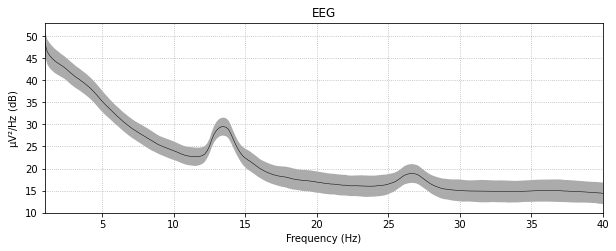

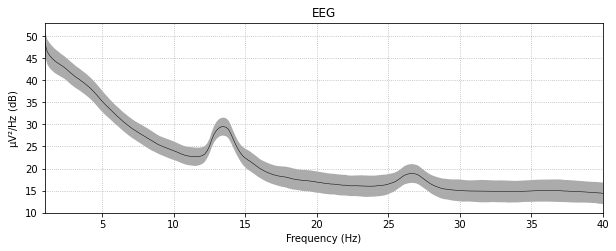

In [7]:
epochs.plot_psd(fmin=1., fmax=40., average=True, spatial_colors=True)

    Using multitaper spectrum estimation with 7 DPSS windows


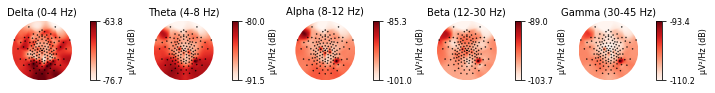

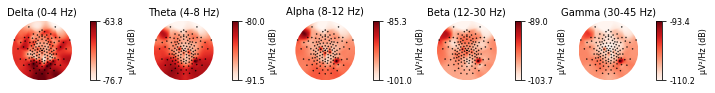

In [8]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=False)

## Function for Calculating PSD

In [9]:
#raw, fmin, fmax
fmin = 0
fmax = 4
raw_avgf = raw_avg.load_data().filter(fmin, fmax, fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 825 samples (1.650 sec)



In [10]:
from matplotlib.mlab import psd
def calculate_psd(raw,fmin,fmax):
    raw_len = len(raw.info['chs'])
    fs = raw.info['sfreq']
    psd_list = []
    for i in range(1,raw_len+1):
        ch = 'E' + str(i)
        #print(ch)
        psd_ch = psd(raw[ch][0].flatten(), NFFT=512, Fs=fs)
        x = np.asarray(psd_ch)
        i = np.where((x[1] > fmin) & (x[1] < fmax))
        ch_mean = np.take(x,i)[0].mean()
        psd_list.append((ch,ch_mean))

    psd_df = pd.DataFrame(psd_list, columns=['Channels','PSD'])
    psd_df = psd_df.sort_values('PSD', ascending= False)
    psd_df
    out  = psd_df[:20]['Channels'].to_list()
    return out

In [11]:
out = calculate_psd(raw_avgf,0,4)
print(out)

['E81', 'E65', 'E73', 'E69', 'E82', 'E88', 'E94', 'E83', 'E74', 'E90', 'E89', 'E70', 'E68', 'E64', 'E96', 'E95', 'E44', 'E107', 'E71', 'E114']


## Check correlation with out

In [12]:
raw_df = raw_avgf.to_data_frame()
raw_df.head()

,time,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E119,E120,E121,E122,E123,E124,E125,E126,E127,E128
0,0,26.687316,27.204592,41.600775,16.115824,9.648600,-2.846219,-3.209687,-13.807557,32.523242,...,-55.062219,32.847678,19.303653,29.638064,50.890425,35.706836,25.683745,-0.314027,-19.519830,-22.673959
1,2,26.130063,26.832520,41.569748,16.156050,9.740047,-2.981024,-3.596167,-13.732796,32.333363,...,-54.322982,32.907849,18.912672,29.228674,50.923366,35.974099,25.134077,-0.742505,-19.828058,-23.155162
2,4,25.572596,26.459723,41.537066,16.193736,9.828966,-3.117807,-3.983812,-13.658868,32.142404,...,-53.584567,32.967635,18.521202,28.818413,50.954986,36.239445,24.584188,-1.171271,-20.136803,-23.636877
3,6,25.014701,26.085479,41.501080,16.226354,9.912837,-3.258534,-4.373783,-13.586606,31.949283,...,-52.847788,33.026650,18.128753,28.406412,50.983969,36.500963,24.033860,-1.600609,-20.446579,-24.119612
4,8,24.456159,25.709075,41.460150,16.251386,9.989155,-3.405156,-4.767225,-13.516841,31.752926,...,-52.113446,33.084514,17.734837,27.991811,51.009006,36.756757,23.482876,-2.030798,-20.757889,-24.603863


In [13]:
#removing shit
sraw_df = raw_df[out]
sraw_df.shape

(600001, 20)

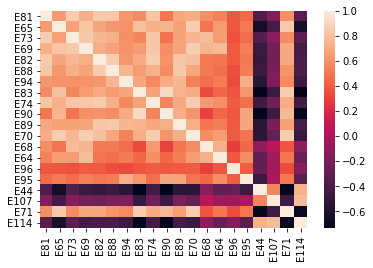

In [14]:
corrMatrix = sraw_df.corr()
#print (corrMatrix)
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrMatrix, annot=False)
plt.show()

In [15]:
cor_matrix = sraw_df.corr().abs()
#print(cor_matrix)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)] #increase threshold to get more channels
# one question to ask -  Is it better with less correlated channels or more correlated channels
print("Removing channels :", to_drop)

['E73', 'E69', 'E82', 'E88', 'E74', 'E90', 'E89', 'E70', 'E71']


<ipython-input-15-c9b3398fc614>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [25]:
cols = [x for x in out if x not in to_drop]
print("Channels used for delta wave extraction :",cols)

Channels used for delta wave extraction : ['E81', 'E65', 'E94', 'E83', 'E68', 'E64', 'E96', 'E95', 'E44', 'E107', 'E114']


## Function to extract delta waves

In [21]:
def extract_deltaWaves(raw,cols):
    del_dict = {'CrossX': [], 'CrossT':[], 'RetX':[], 'RetT':[], 'AmpX':[]}
    srate = raw.info['sfreq']
    for ch in cols:
        # making raw data into pierre compatible data
        print("Extracting delta waves from channel",ch)
        time = raw[ch][1]
        amp = raw[ch][0].flatten()
        result = np.transpose(np.array([time,amp*10e5]))
        file = pd.DataFrame(result, columns = ['Time', 'Amp'])

        fs = raw.info['sfreq'] # sampling frequency
        datdemo = file['Amp'] #taking amplitudes alone

        ### data greater than 250uV or less than -250uV are eliminated
        datdemo = datdemo[datdemo < 250]
        datdemo = datdemo[datdemo > -250]
        datdemo = datdemo.reset_index(drop=True)
        ## preparation for extraction algorithm
        ### the statistical measures:

        moy = float(datdemo.mean())
        stdev = float(datdemo.std())

        ### threshold definitions:

        threshdeb = moy + 0.5 * stdev ### start threshold
        threshfin = moy + 0.4 * stdev ### end threshold
        minduration = 100             ### minimum number of ms of the wave to be considered as a delta wave
        maxduration = 4000

        ### Extraction Algorithm

        CrossX = []
        CrossT = []
        RetX = []
        RetT = []
        AmpX = []
        AmpT = []
        Durations = []              ### the times are also recorded in a list for possible tests.
        N = datdemo.shape[0]
        i = 1

        nbdelta = 0
        reject = 0

        prev = datdemo.iloc[0]

        while i<N:
            val = float(datdemo.iloc[i])
            if val > threshdeb and prev < threshdeb:
                CrossX.append(val)
                CrossT.append(i*(int(1000/srate)))
                locavg = val
                maxamp = val
                maxtime = i*int(1000/srate)
                nloc = 1
                try:
                    while locavg > threshfin and i<N:
                        i+=1
                        locavg = locavg*nloc + float(datdemo.iloc[i])
                        nloc +=1
                        locavg  = locavg/nloc
                        if float(datdemo.iloc[i]) > maxamp:
                            maxamp = float(datdemo.iloc[i])
                            maxtime = i*int(1000/srate)
                    RetX.append(float(datdemo.iloc[i]))
                    RetT.append(i*int(1000/srate))
                    AmpX.append(maxamp)
                    AmpT.append(maxtime)
                    duration = RetT[nbdelta] - CrossT[nbdelta]
                except:
                    print("Error occured while indexing, will have one less delta wave")
                    CrossX.pop()
                    CrossT.pop()
                if duration > minduration and duration < maxduration:
                    nbdelta += 1
                    Durations.append(duration)
                else:
                    del CrossX[nbdelta]
                    del CrossT[nbdelta]
                    del RetX[nbdelta]
                    del RetT[nbdelta]
                    del AmpX[nbdelta]
                    del AmpT[nbdelta]
                    reject += 1
            prev = val
            i = i+1 
        #print(len(CrossX),len(CrossT),len(RetX),len(RetT),len(AmpX))
        print(ch,": Number of delta waves detected :",nbdelta, " Number of delta waves rejected :", reject)

        if len(CrossX) == nbdelta or len(CrossX) == nbdelta - 1 :
            del_dict['CrossX'] = del_dict['CrossX'] + CrossX
            del_dict['CrossT'] = del_dict['CrossT'] + CrossT
            del_dict['RetX'] = del_dict['RetX'] + RetX
            del_dict['RetT'] = del_dict['RetT'] + RetT
            del_dict['AmpX'] = del_dict['AmpX'] + AmpX
        else :
            print("Size not equal")
    print("------------- Done extracting delta waves -------------")
    del_df = pd.DataFrame.from_dict(del_dict)
    print("Total number of delta waves", del_df.shape[0])
    return del_df

In [22]:
df = extract_deltaWaves(raw_avg,cols)
df.to_csv(r'out_test.txt', header=None, index=None, sep=' ', mode='a')

Extracting delta waves from channel E81
E81 : Number of delta waves detected : 305  Number of delta waves rejected : 68
Extracting delta waves from channel E65
Error occured while indexing, will have one less delta wave
E65 : Number of delta waves detected : 248  Number of delta waves rejected : 71
Extracting delta waves from channel E94
E94 : Number of delta waves detected : 411  Number of delta waves rejected : 85
Extracting delta waves from channel E83
Error occured while indexing, will have one less delta wave
E83 : Number of delta waves detected : 235  Number of delta waves rejected : 66
Extracting delta waves from channel E68
Error occured while indexing, will have one less delta wave
E68 : Number of delta waves detected : 426  Number of delta waves rejected : 87
Extracting delta waves from channel E64
Error occured while indexing, will have one less delta wave
E64 : Number of delta waves detected : 452  Number of delta waves rejected : 102
Extracting delta waves from channel E96

In [23]:
# writing in text file for Alain to synthesize music
res = open("out_test.txt", "r+")
temp = res.read()
res.seek(0,0)
res.write(str(df.shape[0]))
res.write("\n")
res.write(temp)
res.close()